# Modeling of the thickness of the sensor

In this notebook we will re-use the experiment done at ID28 and previously calibrated and model in 3D the detector.

This detector is a Pilatus 1M with a 450µm thick silicon sensor. Let's first have a look at the absorption coefficients of this sensor material: https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z14.html

First we retieve the results of the previous step, then calculate the absorption efficiency:

In [1]:
%matplotlib inline
# use `widget` instead of `inline` for better user-experience. `inline` allows to store plots into notebooks.

In [22]:
import time
import random
from matplotlib.pyplot import subplots
import numpy
from scipy.sparse import save_npz
import fabio
import pyFAI
import pyFAI.units
import pyFAI.detectors
from pyFAI.detectors.sensors import Si_MATERIAL
import json
from scipy.sparse import csr_matrix, csc_matrix, linalg

start_time = time.perf_counter()
print(f"Using pyFAI vesrion: {pyFAI.version}")
with open("id28.json") as f:
    calib = json.load(f)

thickness = 450e-6
wavelength = calib["wavelength"]
dist = calib["param"][calib['param_names'].index("dist")]
poni1 = calib["param"][calib['param_names'].index("poni1")]
poni2 = calib["param"][calib['param_names'].index("poni2")]
energy = pyFAI.units.hc/(wavelength*1e10)
print("wavelength: %.3em,\t dist: %.3em,\t poni1: %.3em,\t poni2: %.3em,\t energy: %.3fkeV" % 
      (wavelength, dist, poni1, poni2, energy))
mask = numpy.load("mask.npy").astype(numpy.int8)

Using pyFAI vesrion: 2025.10.0-dev0
wavelength: 6.968e-11m,	 dist: 2.845e-01m,	 poni1: 8.865e-02m,	 poni2: 8.931e-02m,	 energy: 17.793keV


## Absorption coefficient at 17.8 keV

In [3]:
print(f"µ = {Si_MATERIAL.mu(energy, unit="cm"):.1f} cm^-1 "
      f"hence absorption efficiency for 450µm: {100*Si_MATERIAL.absorbance(energy, thickness):.1f} %")
mu = Si_MATERIAL.mu(energy, unit="m")

µ = 16.4 cm^-1 hence absorption efficiency for 450µm: 52.3 %


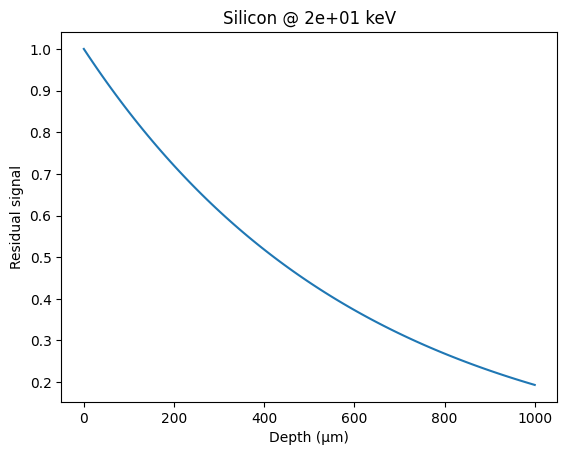

In [4]:
from pyFAI.detectors.sensors import Si_MATERIAL
depth = numpy.linspace(0, 1000, 100)
res = [1-Si_MATERIAL.absorbance(energy, d, "µm") for d in depth]
fig, ax = subplots()
ax.plot(depth, res, "-")
ax.set_xlabel("Depth (µm)")
ax.set_ylabel("Residual signal")
ax.set_title(f"Silicon @ {energy:.1} keV");

This is consistent with:
[henke.lbl.gov](http://henke.lbl.gov/optical_constants/filter2.html) or 
[web-docs.gsi.de](https://web-docs.gsi.de/~stoe_exp/web_programs/x_ray_absorption/index.php)

Now we can model the detector

## Modeling of the detector:

The detector is represented as a 2D array of voxels. Let vox, voy, and voz denote the dimensions of the detector along the three axes.


In [5]:
detector= pyFAI.detector_factory(calib["detector"])
print(detector)

vox = detector.pixel2 # this is not a typo
voy = detector.pixel1 # x <--> axis 2
voz = thickness

print(f"Voxel size: (x:{vox}, y:{voy}, z:{voz})")

Detector Pilatus 1M	PixelSize= 172µm, 172µm	 BottomRight(3)
Voxel size: (x:0.000172, y:0.000172, z:0.00045)


The intensity grabbed in this voxel is the triple integral of the absorbed signal coming from this pixel or from the neighboring ones.

There are 3 ways to perform this intergral:
* Volumetric analytic integral. Looks feasible with a change of variable in the depth
* Slice per slice, the remaining intensity depand on the incidence angle + pixel splitting between neighbooring pixels
* raytracing: the decay can be solved analytically for each ray, one has to throw many ray to average out the signal.

For sake of simplicity, this integral will be calculated numerically using this raytracing algorithm.
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.42.3443&rep=rep1&type=pdf

Knowing the input position for a X-ray on the detector and its propagation vector, this algorithm allows us to calculate  the length of the path in all voxel it crosses in a fairly efficient way.

To speed up the calculation, we will use a few tricks:
* One ray never crosses more than 16 pixels, which is reasonable considering the incidance angle 
* we use numba to speed-up the calculation of loops in python
* We will allocate the needed memory by chuncks of 1 million elements


In [6]:
! pip install numba cython

## Raytracing using numba

In [7]:
from numba import jit 

BLOCK_SIZE = 1<<20 # 1 million
BUFFER_SIZE = 16 
BIG = numpy.finfo(numpy.float32).max



Now that we are able to perform raytracing for any ray entering the detector, we can calculate the contribution to the neighboring pixels, using the absorption law (the length traveled is already known). 
To average-out the signal, we will sample a few dozens of rays per pixel to get an approximation of the volume integral. 

Now we need to store the results so that this transformation can be represented as a sparse matrix multiplication:

b = M.a

Where b is the recorded image (blurred) and a is the "perfect" signal. 
M being the sparse matrix where every pixel of a gives a limited number of contribution to b.

Each pixel in *b* is represented by one line in *M* and we store the indices of *a* of interest with the coefficients of the matrix.
So if a pixel i,j contributes to (i,j), (i+1,j), (i+1,j+1), there are only 3 elements in the line. 
This is advantageous for storage.

We will use the CSR sparse matrix representation:
https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_.28CSR.2C_CRS_or_Yale_format.29
where there are 3 arrays:
* data: containing the actual non zero values
* indices: for a given line, it contains the column number of the associated data (at the same indice)
* idptr: this array contains the index of the start of every line.


In [8]:
from numba.experimental import jitclass
from numba import int8, int32, int64, float32, float64
spec = [("vox",float64),("voy",float64),("voz",float64),("mu",float64),
        ("dist",float64),("poni1",float64),("poni2",float64),
        ("width", int64),("height", int64),("mask", int8[:,:]),
        ("sampled", int64), ("data", float32[:]),("indices", int32[:]),("idptr", int32[:]),
       ]
@jitclass(spec)
class ThickDetector(object):
    "Calculate the point spread function as function of the geometry of the experiment"
    
    def __init__(self, vox, voy, thickness, mask, mu, 
                 dist, poni1, poni2):
        """Constructor of the class:
        
        :param vox, voy: detector pixel size in the plane
        :param thickness: thickness of the sensor in meters
        :param mask: 
        :param mu: absorption coefficient of the sensor material
        :param dist: sample detector distance as defined in the geometry-file
        :param poni1, poni2: coordinates of the PONI as defined in the geometry 
        """
        self.vox = vox
        self.voy = voy
        self.voz = thickness
        self.mu = mu
        self.dist=dist
        self.poni1 = poni1
        self.poni2 = poni2
        self.width = mask.shape[-1]
        self.height = mask.shape[0]
        self.mask = mask
        self.sampled = 0
        self.data = numpy.zeros(BLOCK_SIZE, dtype=numpy.float32)
        self.indices = numpy.zeros(BLOCK_SIZE,dtype=numpy.int32)
        self.idptr = numpy.zeros(self.width*self.height+1, dtype=numpy.int32)
        
    def calc_one_ray(self, entx, enty):
        """For a ray entering at position (entx, enty), with a propagation vector (kx, ky,kz),
        calculate the length spent in every voxel where energy is deposited from a bunch of photons entering the detector 
        at a given position and and how much energy they deposit in each voxel. 

        Direct implementation of http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.42.3443&rep=rep1&type=pdf

        :param entx, enty: coordinate of the entry point in meter (2 components, x,y)
        :return: coordinates voxels in x, y and length crossed when leaving the associated voxel
        """
        array_x = numpy.empty(BUFFER_SIZE, dtype=numpy.int32)
        array_x[:] = -1
        array_y = numpy.empty(BUFFER_SIZE, dtype=numpy.int32)
        array_y[:] = -1
        array_len = numpy.empty(BUFFER_SIZE, dtype=numpy.float32)

        #normalize the input propagation vector
        kx = entx - self.poni2
        ky = enty - self.poni1
        kz = self.dist
        n = numpy.sqrt(kx*kx + ky*ky + kz*kz)
        kx /= n
        ky /= n
        kz /= n

        step_X = -1 if kx<0.0 else 1
        step_Y = -1 if ky<0.0 else 1

        X = int(entx/self.vox)
        Y = int(enty/self.voy)

        if kx>0.0:
            t_max_x = ((entx//self.vox+1)*(self.vox)-entx)/ kx
        elif kx<0.0:
            t_max_x = ((entx//self.vox)*(self.vox)-entx)/ kx
        else:
            t_max_x = BIG

        if ky>0.0:
            t_max_y = ((enty//self.voy+1)*(self.voy)-enty)/ ky
        elif ky<0.0:
            t_max_y = ((enty//self.voy)*(self.voy)-enty)/ ky
        else:
            t_max_y = BIG

        #Only one case for z as the ray is travelling in one direction only
        t_max_z = self.voz / kz

        t_delta_x = abs(self.vox/kx) if kx!=0 else BIG
        t_delta_y = abs(self.voy/ky) if ky!=0 else BIG
        t_delta_z = self.voz/kz

        finished = False
        last_id = 0
        array_x[last_id] = X
        array_y[last_id] = Y

        while not finished:
            if t_max_x < t_max_y:
                if t_max_x < t_max_z:
                    array_len[last_id] = t_max_x
                    last_id+=1
                    X += step_X
                    array_x[last_id] = X
                    array_y[last_id] = Y
                    t_max_x += t_delta_x
                else:
                    array_len[last_id] = t_max_z
                    last_id+=1
                    finished = True
            else:
                if t_max_y < t_max_z:
                    array_len[last_id] = t_max_y
                    last_id+=1
                    Y += step_Y
                    array_x[last_id] = X
                    array_y[last_id] = Y                
                    t_max_y += t_delta_y
                else:
                    array_len[last_id] = t_max_z
                    last_id+=1
                    finished = True
            if last_id>=array_len.size-1:
                print("resize arrays")
                old_size = len(array_len)
                new_size = (old_size//BUFFER_SIZE+1)*BUFFER_SIZE
                new_array_x = numpy.empty(new_size, dtype=numpy.int32)
                new_array_x[:] = -1
                new_array_y = numpy.empty(new_size, dtype=numpy.int32)
                new_array_y[:] = -1
                new_array_len = numpy.empty(new_size, dtype=numpy.float32)
                new_array_x[:old_size] = array_x
                new_array_y[:old_size] = array_y
                new_array_len[:old_size] = array_len
                array_x = new_array_x
                array_y = new_array_y
                array_len = new_array_len
        return array_x[:last_id], array_y[:last_id], array_len[:last_id]

    def one_pixel(self, row, col, sample):
        """calculate the contribution of one pixel to the sparse matrix and populate it.

        :param row: row index of the pixel of interest
        :param col: column index of the pixel of interest
        :param sample: Oversampling rate, 10 will cast 10x10 ray per pixel

        :return: the extra number of pixel allocated
        """
        if self.mask[row, col]:
            return (numpy.empty(0, dtype=numpy.int32),
                    numpy.empty(0, dtype=numpy.float32))

        counter = 0
        tmp_size = 0
        last_buffer_size = BUFFER_SIZE
        tmp_idx = numpy.empty(last_buffer_size, dtype=numpy.int32)
        tmp_idx[:] = -1
        tmp_coef = numpy.zeros(last_buffer_size, dtype=numpy.float32)

        pos = row * self.width + col
        start = self.idptr[pos]
        for i in range(sample):
            posx = (col+1.0*i/sample)*vox
            for j in range(sample):
                posy = (row+1.0*j/sample)*voy
                array_x, array_y, array_len = self.calc_one_ray(posx, posy)

                rem = 1.0
                for i in range(array_x.size):
                    x = array_x[i]
                    y = array_y[i]
                    l = array_len[i]
                    if (x<0) or (y<0) or (y>=self.height) or (x>=self.width):
                        break
                    elif (self.mask[y, x]):
                        continue
                    idx = x + y*self.width
                    dos = numpy.exp(-self.mu*l)
                    value = rem - dos
                    rem = dos
                    for j in range(last_buffer_size):
                        if tmp_size >= last_buffer_size:
                            #Increase buffer size
                            new_buffer_size = last_buffer_size + BUFFER_SIZE
                            new_idx = numpy.empty(new_buffer_size, dtype=numpy.int32)
                            new_coef = numpy.zeros(new_buffer_size, dtype=numpy.float32)
                            new_idx[:last_buffer_size] = tmp_idx
                            new_idx[last_buffer_size:] = -1
                            new_coef[:last_buffer_size] = tmp_coef
                            last_buffer_size = new_buffer_size
                            tmp_idx = new_idx
                            tmp_coef = new_coef

                        if tmp_idx[j] == idx:
                            tmp_coef[j] += value
                            break
                        elif tmp_idx[j] < 0:
                            tmp_idx[j] = idx
                            tmp_coef[j] = value
                            tmp_size +=1
                            break     
        return tmp_idx[:tmp_size], tmp_coef[:tmp_size]

    def calc_csr(self, sample):
        """Calculate the CSR matrix for the whole image
        :param sample: Oversampling factor
        :return: CSR matrix
        """
        size = self.width * self.height
        allocated_size = BLOCK_SIZE
        idptr = numpy.zeros(size+1, dtype=numpy.int32) 
        indices = numpy.zeros(allocated_size, dtype=numpy.int32)
        data = numpy.zeros(allocated_size, dtype=numpy.float32)
        self.sampled = sample*sample
        pos = 0
        start = 0
        for row in range(self.height):
            for col in range(self.width):    
                line_idx, line_coef = self.one_pixel(row, col, sample)
                line_size = line_idx.size
                if line_size == 0:
                    new_size = 0
                    pos+=1
                    idptr[pos] = start
                    continue

                stop = start + line_size
                
                if stop >= allocated_size:
                    new_buffer_size = allocated_size +  BLOCK_SIZE
                    new_idx = numpy.zeros(new_buffer_size, dtype=numpy.int32)
                    new_coef = numpy.zeros(new_buffer_size, dtype=numpy.float32)
                    new_idx[:allocated_size] = indices
                    new_coef[:allocated_size] = data
                    allocated_size = new_buffer_size
                    indices = new_idx
                    data = new_coef

                indices[start:stop] = line_idx
                data[start:stop] = line_coef
                pos+=1
                idptr[pos] = stop
                start = stop
    
        last = idptr[-1]
        self.data = data
        self.indices = indices
        self.idptr = idptr
        return (self.data[:last]/self.sampled, indices[:last], idptr)


In [9]:
nbthick = ThickDetector(vox,voy, thickness=thickness, mu=mu, dist=dist, poni1=poni1, poni2=poni2, mask=mask)
%time nbthick.calc_csr(1)

CPU times: user 3.9 s, sys: 271 ms, total: 4.17 s
Wall time: 4.18 s


(array([0., 0., 0., ..., 0., 0., 0.], shape=(1902583,), dtype=float32),
 array([      2,       2,       4, ..., 1023180, 1023181, 1023182],
       shape=(1902583,), dtype=int32),
 array([      0,       0,       0, ..., 1902581, 1902582, 1902583],
       shape=(1023184,), dtype=int32))

In [10]:
%time nbthick.calc_csr(4)

CPU times: user 3.7 s, sys: 39.9 ms, total: 3.74 s
Wall time: 3.72 s


(array([0.17449115, 0.10933631, 0.17465518, ..., 0.24611568, 0.03161056,
        0.24604346], shape=(3410359,), dtype=float32),
 array([      2,       2,       3, ..., 1023181, 1023182, 1023182],
       shape=(3410359,), dtype=int32),
 array([      0,       0,       0, ..., 3410356, 3410358, 3410359],
       shape=(1023184,), dtype=int32))

## Same implementation using Cython

Cython is an ahead of time compiler for Python code. Thus it requires a compiler (gcc, msvc, ...) needs to be installed on your computer and available. This is usually already the case under linux but requires some work under windows or macos.

In [11]:
%load_ext Cython

In [12]:
%%cython 
#cython: embedsignature=True, language_level=3, binding=True
#cython: boundscheck=False, wraparound=False, cdivision=True, initializedcheck=False,
## This is for developping:
## cython: profile=True, warn.undeclared=True, warn.unused=True, warn.unused_result=False, warn.unused_arg=True
##--compile-args=-fopenmp --link-args=-fopenmp

import cython
import numpy
from libc.math cimport sqrt, exp
from cython.parallel import prange
from libc.stdint cimport int8_t, uint8_t, int16_t, uint16_t, \
                         int32_t, uint32_t, int64_t, uint64_t

ctypedef double float64_t
ctypedef float float32_t

cdef int32_t BUFFER_SIZE = 16
cdef float64_t BIG = numpy.finfo(numpy.float32).max


cdef class CythonThickDetector:
    "Calculate the point spread function as function of the geometry of the experiment"
    cdef:
        public float64_t vox
        public float64_t voy
        public float64_t voz
        public float64_t mu
        public float64_t dist
        public float64_t poni1
        public float64_t poni2
        public int oversampling
        public int buffer_size
        public int width
        public int height
        public int size
        public int8_t[:, ::1] mask
    
    def __init__(self, 
                 float64_t vox, 
                 float64_t voy, 
                 float64_t thickness, 
                 mask, 
                 float64_t mu, 
                 float64_t dist, 
                 float64_t poni1, 
                 float64_t poni2,
                 int buffer_size=BUFFER_SIZE):
        """Constructor of the class:
        
        :param vox, voy: detector pixel size in the plane
        :param thickness: thickness of the sensor in meters
        :param mask: 
        :param mu: absorption coefficient of the sensor material
        :param dist: sample detector distance as defined in the geometry-file
        :param poni1, poni2: coordinates of the PONI as defined in the geometry 
        """
        self.vox = float(vox)
        self.voy = float(voy)
        self.voz = float(thickness)
        self.mu = float(mu)
        self.dist = float(dist)
        self.poni1 = float(poni1)
        self.poni2 = float(poni2)
        self.width = int(mask.shape[1])
        self.height = int(mask.shape[0])
        self.size = self.width*self.height
        self.mask = numpy.ascontiguousarray(mask, numpy.int8)
        self.oversampling = 1
        self.buffer_size = int(buffer_size)
                
    def calc_one_ray(self, entx, enty):
        """For a ray entering at position (entx, enty), with a propagation vector (kx, ky,kz),
        calculate the length spent in every voxel where energy is deposited from a bunch of photons entering the detector 
        at a given position and and how much energy they deposit in each voxel. 

        Direct implementation of http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.42.3443&rep=rep1&type=pdf

        :param entx, enty: coordinate of the entry point in meter (2 components, x,y)
        :return: coordinates voxels in x, y and length crossed when leaving the associated voxel
        """
        
        cdef:
            int last_id
            float64_t _entx = float(entx)
            float64_t _enty = float(enty)
            int32_t[::1] array_x = numpy.empty(self.buffer_size, dtype=numpy.int32)
            int32_t[::1] array_y = numpy.empty(self.buffer_size, dtype=numpy.int32)
            float32_t[::1] array_len = numpy.empty(self.buffer_size, dtype=numpy.float32)
        with nogil: 
            last_id = self._calc_one_ray(_entx, _enty, 
                                         array_x, array_y, array_len)
        if last_id>self.buffer_size:
            raise RuntimeError(f"Temporary buffer size ({last_id}) larger than expected ({self.buffer_size})")
        return (numpy.asarray(array_x[:last_id]), 
                numpy.asarray(array_y[:last_id]), 
                numpy.asarray(array_len[:last_id]))
        
    cdef int _calc_one_ray(self, 
                           float64_t entx, 
                           float64_t enty,
                           int32_t[::1] array_x,
                           int32_t[::1] array_y,
                           float32_t[::1] array_len
                          )noexcept nogil:
        """Return number of entries in the array_x[:last_id], array_y[:last_id], array_len[:last_id]"""
        cdef:
            float64_t kx, ky, kz, n, t_max_x, t_max_y, t_max_z, t_delta_x, t_delta_y#, t_delta_z
            int step_X, step_Y, X, Y, last_id
            bint finished

        # reset arrays
        array_x[:] = -1
        array_y[:] = -1
        array_len[:] = 0.0

        # normalize the input propagation vector
        kx = entx - self.poni2
        ky = enty - self.poni1
        kz = self.dist
        n = sqrt(kx*kx + ky*ky + kz*kz)
        kx /= n
        ky /= n
        kz /= n

        step_X = -1 if kx<0.0 else 1
        step_Y = -1 if ky<0.0 else 1

        X = int(entx/self.vox)
        Y = int(enty/self.voy)

        if kx>0.0:
            t_max_x = ((entx//self.vox+1)*(self.vox)-entx)/ kx
        elif kx<0.0:
            t_max_x = ((entx//self.vox)*(self.vox)-entx)/ kx
        else:
            t_max_x = BIG

        if ky>0.0:
            t_max_y = ((enty//self.voy+1)*(self.voy)-enty)/ ky
        elif ky<0.0:
            t_max_y = ((enty//self.voy)*(self.voy)-enty)/ ky
        else:
            t_max_y = BIG

        #Only one case for z as the ray is travelling in one direction only
        t_max_z = self.voz / kz

        t_delta_x = abs(self.vox/kx) if kx!=0 else BIG
        t_delta_y = abs(self.voy/ky) if ky!=0 else BIG
        # t_delta_z = self.voz/kz

        finished = False
        last_id = 0
        array_x[last_id] = X
        array_y[last_id] = Y

        while not finished:
            if t_max_x < t_max_y:
                if t_max_x < t_max_z:
                    array_len[last_id] = t_max_x
                    last_id += 1
                    X += step_X
                    array_x[last_id] = X
                    array_y[last_id] = Y
                    t_max_x += t_delta_x
                else:
                    array_len[last_id] = t_max_z
                    last_id += 1
                    finished = True
            else:
                if t_max_y < t_max_z:
                    array_len[last_id] = t_max_y
                    last_id+=1
                    Y += step_Y
                    array_x[last_id] = X
                    array_y[last_id] = Y                
                    t_max_y += t_delta_y
                else:
                    array_len[last_id] = t_max_z
                    last_id+=1
                    finished = True
            if last_id>=array_len.shape[0]:
                with gil:
                    old_size = array_len.shape[0]
                    new_size = old_size+self.buffer_size
                    print(f"resize arrays {old_size} -> new_size")
                    new_array_x = numpy.empty(new_size, dtype=numpy.int32)
                    new_array_y = numpy.empty(new_size, dtype=numpy.int32)
                    new_array_len = numpy.empty(new_size, dtype=numpy.float32)
                    new_array_x[:] = -1
                    new_array_y[:] = -1
                    new_array_len[:] = 0
                    new_array_x[:old_size] = self.array_x
                    new_array_y[:old_size] = self.array_y
                    new_array_len[:old_size] = self.array_len
                    array_x = new_array_x
                    array_y = new_array_y
                    array_len = new_array_len
        return last_id


    def one_pixel(self, row, col, sample=0):
        """calculate the contribution of one pixel to the sparse matrix and populate it.

        :param row: row index of the pixel of interest
        :param col: column index of the pixel of interest
        :param sample: Oversampling rate, 10 will cast 10x10 ray per pixel
        """
        cdef:
            int entries = 0
            int _row = int(row)
            int _col = int(col) 
            int32_t[::1] tmp_idx = numpy.empty(self.buffer_size, dtype=numpy.int32)
            float32_t[::1] tmp_coef = numpy.empty(self.buffer_size, dtype=numpy.float32)
            int32_t[::1] array_x = numpy.empty(self.buffer_size, dtype=numpy.int32)
            int32_t[::1] array_y = numpy.empty(self.buffer_size, dtype=numpy.int32)
            float32_t[::1] array_len = numpy.empty(self.buffer_size, dtype=numpy.float32)

        if  sample:
            self.oversampling = sample
        with nogil:
            entries = self._one_pixel(_row, _col, tmp_idx, tmp_coef, array_x, array_y, array_len)
        if entries<self.buffer_size:
            return (numpy.asarray(tmp_idx)[:entries],numpy.asarray(tmp_coef)[:entries])
        else:
            raise RuntimeError(f"Pixel produced {entries} voxels, limited to {self.buffer_size}. Increase Buffer size ! in constructor")

    cdef int _one_pixel(self, int row, int col,
                       int32_t[::1] tmp_idx,
                       float32_t[::1] tmp_coef,
                       int32_t[::1] array_x,
                       int32_t[::1] array_y,
                       float32_t[::1] array_len
                    )noexcept nogil:
        "return the number of elements in tmp_idx/tmp_coef which are to be used"
        
        cdef:
            int i, j, tmp_size, last_buffer_size, n, x, y, idx
            float64_t rem, l, posx, posy, value, dos

        if self.mask[row, col]:
            return 0

        tmp_size = 0
        last_buffer_size = tmp_idx.shape[0]
        tmp_idx[:] = -1
        tmp_coef[:] = 0.0

        for i in range(self.oversampling):
            posx = (col+1.0*i/self.oversampling)*self.vox
            for j in range(self.oversampling):
                posy = (row+1.0*j/self.oversampling)*self.voy
                n = self._calc_one_ray(posx, posy, array_x, array_y, array_len)
                rem = 1.0
                for i in range(n):
                    x = array_x[i]
                    y = array_y[i]
                    l = array_len[i]
                    if (x<0) or (y<0) or (y>=self.height) or (x>=self.width):
                        break
                    elif (self.mask[y, x]):
                        continue
                    idx = x + y*self.width
                    dos = exp(-self.mu*l)
                    value = rem - dos
                    rem = dos
                    for j in range(last_buffer_size):
                        if tmp_size >= last_buffer_size:
                            with gil:
                                new_buffer_size = last_buffer_size + self.buffer_size
                                print(f"Increase buffer size {last_buffer_size} -> {new_buffer_size}")
                                new_idx = numpy.empty(new_buffer_size, dtype=numpy.int32)
                                new_coef = numpy.zeros(new_buffer_size, dtype=numpy.float32)
                                new_idx[:last_buffer_size] = tmp_idx
                                new_idx[last_buffer_size:] = -1
                                new_coef[:last_buffer_size] = tmp_coef
                                last_buffer_size = new_buffer_size
                                tmp_idx = new_idx
                                tmp_coef = new_coef

                        if tmp_idx[j] == idx:
                            tmp_coef[j] += value
                            break
                        elif tmp_idx[j] < 0:
                            tmp_idx[j] = idx
                            tmp_coef[j] = value
                            tmp_size +=1
                            break     
        return tmp_size

    def calc_csr(self, sample=0, int threads=0):
        """Calculate the content of the sparse matrix for the whole image
        :param sample: Oversampling factor
        :param threads: number of threads to be used
        :return: spase matrix?
        """
        cdef:
            int pos, i, current, next, size
            int32_t[::1] sizes, indptr = numpy.zeros(self.size+1, dtype=numpy.int32)
            int32_t[:, ::1] indices
            float32_t[:, ::1] data
            int32_t[::1] csr_indices
            float32_t[::1] csr_data
            int32_t[:, ::1] array_x
            int32_t[:, ::1] array_y
            float32_t[:, ::1] array_len

        if sample:
            self.oversampling = sample
        self.oversampling = sample
        data = numpy.zeros((self.size, self.buffer_size), dtype=numpy.float32)
        indices = numpy.zeros((self.size, self.buffer_size),dtype=numpy.int32)
        sizes = numpy.zeros(self.size, dtype=numpy.int32)

        #single threaded version:
        array_x = numpy.empty((self.size, self.buffer_size), dtype=numpy.int32)
        array_y = numpy.empty((self.size, self.buffer_size), dtype=numpy.int32)
        array_len = numpy.empty((self.size, self.buffer_size), dtype=numpy.float32)

        for pos in prange(self.size, num_threads=threads, nogil=True):
            size = sizes[pos] = self._one_pixel(pos//self.width, pos%self.width, 
                                             indices[pos], data[pos], 
                                             array_x[pos], array_y[pos], array_len[pos])
        size = numpy.sum(sizes)
        csr_indices = numpy.empty(size, numpy.int32)
        csr_data = numpy.empty(size, numpy.float32)
        current = 0
        for i in range(self.size):
            size = sizes[i]
            next = current + size
            indptr[i+1] = next
            csr_indices[current:next] = indices[i,:size]
            csr_data[current:next] = data[i,:size]
            current = next
        return (numpy.asarray(csr_data)/(self.oversampling*self.oversampling), 
                numpy.asarray(csr_indices), 
                numpy.asarray(indptr))

In [13]:
cythick = CythonThickDetector(172e-6,172e-6, thickness=thickness, mu=mu, dist=dist, poni1=poni1, poni2=poni2, mask=mask)
%time cythick.calc_csr(4)

CPU times: user 2.18 s, sys: 23.9 ms, total: 2.2 s
Wall time: 2.21 s


(array([0.17449115, 0.10933631, 0.17465518, ..., 0.35667214, 0.05905784,
        0.35653958], shape=(3328700,), dtype=float32),
 array([      2,       2,       3, ..., 1023181, 1023182, 1023182],
       shape=(3328700,), dtype=int32),
 array([      0,       0,       0, ..., 3328697, 3328699, 3328700],
       shape=(1023184,), dtype=int32))

In [14]:
# Comparison with Numba, Cython is usually slightly faster
%time nbthick.calc_csr(4)

CPU times: user 3.75 s, sys: 24.1 ms, total: 3.77 s
Wall time: 3.75 s


(array([0.17449115, 0.10933631, 0.17465518, ..., 0.24611568, 0.03161056,
        0.24604346], shape=(3410359,), dtype=float32),
 array([      2,       2,       3, ..., 1023181, 1023182, 1023182],
       shape=(3410359,), dtype=int32),
 array([      0,       0,       0, ..., 3410356, 3410358, 3410359],
       shape=(1023184,), dtype=int32))

## Validation of the CSR matrix obtained:

For this we will build a simple 2D image with one pixel in a regular grid and calculate the effect of the transformation calculated previously on it. 

In [15]:
%time csr = csr_matrix(cythick.calc_csr(10))

CPU times: user 11.5 s, sys: 32.5 ms, total: 11.5 s
Wall time: 11.5 s


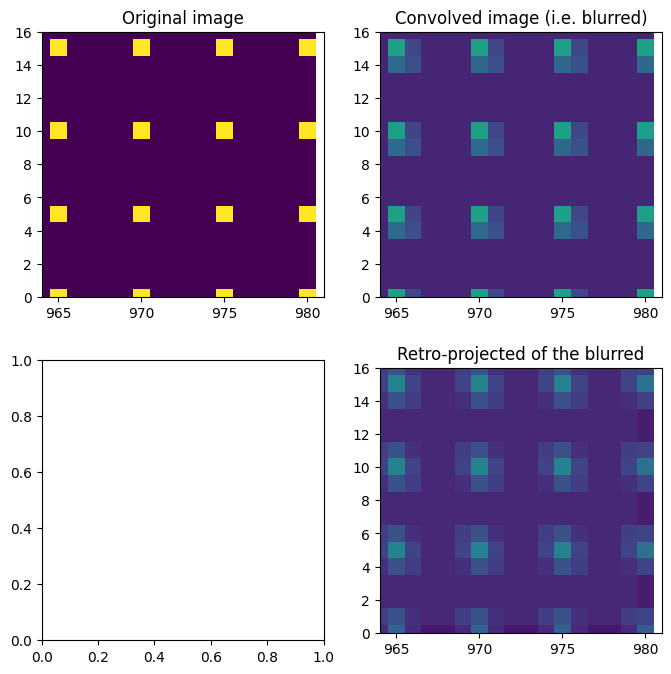

In [16]:
dummy_image = numpy.ones(mask.shape, dtype="float32")
dummy_image[::5,::5] = 10
#dummy_image[mask] = -1
dummy_blurred = csr.T.dot(dummy_image.ravel()).reshape(mask.shape)
fix, ax = subplots(2,2, figsize=(8,8))
ax[0,0].imshow(dummy_image)
ax[0,0].set_title("Original image")
ax[0,1].imshow(dummy_blurred)
ax[0,1].set_title("Convolved image (i.e. blurred)")
ax[1,1].imshow(csr.dot(dummy_blurred.ravel()).reshape(mask.shape));
ax[1,1].set_title("Retro-projected of the blurred")
ax[0,0].set_xlim(964,981)
ax[0,0].set_ylim(0,16)
ax[0,1].set_xlim(964,981)
ax[0,1].set_ylim(0,16)
ax[1,1].set_xlim(964,981)
ax[1,1].set_ylim(0,16);

# Least squares refinement of the pseudo-inverse

/users/kieffer/.venv/py313/lib/python3.13/site-packages/scipy/sparse/linalg/_isolve/lsmr.py:407: RuntimeWarning: overflow encountered in cast
  condA = max(maxrbar, rhotemp) / min(minrbar, rhotemp)
/users/kieffer/.venv/py313/lib/python3.13/site-packages/scipy/sparse/linalg/_isolve/lsmr.py:406: RuntimeWarning: overflow encountered in cast
  minrbar = min(minrbar, rhobarold)


CPU times: user 28.9 s, sys: 7.55 ms, total: 28.9 s
Wall time: 493 ms


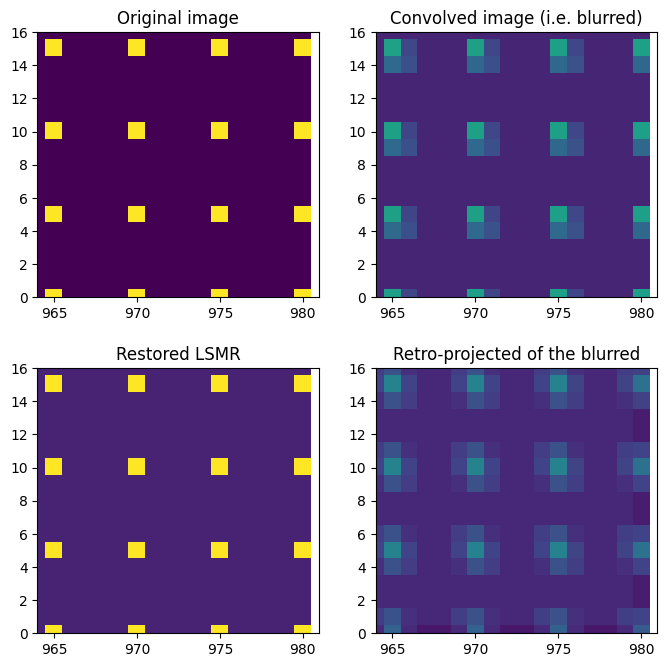

In [17]:
blured = dummy_blurred.ravel()

# Invert this matrix: see https://arxiv.org/abs/1006.0758

%time res = linalg.lsmr(csr.T, blured)
restored = res[0].reshape(mask.shape)

fix, ax = subplots(2,2, figsize=(8,8))
ax[0,0].imshow(dummy_image)
ax[0,0].set_title("Original image")
ax[0,1].imshow(dummy_blurred)
ax[0,1].set_title("Convolved image (i.e. blurred)")
ax[1,1].imshow(csr.dot(dummy_blurred.ravel()).reshape(mask.shape));
ax[1,1].set_title("Retro-projected of the blurred")
ax[0,0].set_xlim(964,981)
ax[0,0].set_ylim(0,16)
ax[0,1].set_xlim(964,981)
ax[0,1].set_ylim(0,16)
ax[1,1].set_xlim(964,981)
ax[1,1].set_ylim(0,16);
ax[1,0].imshow(restored)
ax[1,0].set_title("Restored LSMR")
ax[1,0].set_xlim(964,981)
ax[1,0].set_ylim(0,16);

# print(res[1:])

# Pseudo inverse with positivitiy constrain and poissonian noise (MLEM)

The MLEM algorithm was initially developed within the framework of reconstruction of
images in emission tomography [Shepp and Vardi, 1982], [Vardi et al., 1985], [Lange and
Carson, 1984]. Nowadays, this algorithm is employed in numerous tomographic reconstruction
problems and often associated to regularization techniques. It is based on the iterative
maximization of the log-likelihood function.

In [18]:
def iterMLEM_scipy(F, M, R):
    "Implement one step of MLEM"
    #res = F * (R.T.dot(M))/R.dot(F)# / M.sum(axis=-1)
    norm = 1/R.T.dot(numpy.ones_like(F)) 
    cor = R.T.dot(M/R.dot(F))
    res = norm * F * cor
    res[numpy.isnan(res)] = 1.0
    return res

def deconv_MLEM(csr, data, thres=0.2, maxiter=1000):
    R = csr.T
    msk = data<0
    img = data.astype("float32")
    img[msk] = 0.0 # set masked values to 0, negative values could induce errors
    M = img.ravel()
    #F0 = numpy.random.random(data.size)#M#
    F0 = R.T.dot(M)
    F1 = iterMLEM_scipy(F0, M, R)
    delta = abs(F1-F0).max()
    for i in range(maxiter):
        if delta<thres:
            break
        F2 = iterMLEM_scipy(F1, M, R)
        delta = abs(F1-F2).max()
        if i%100==0:
            print(i, delta)
        F1 = F2
        i+=1
    print(i, delta)
    return F2.reshape(img.shape)

%time res = deconv_MLEM(csr, dummy_blurred, 1e-4)

/tmp/ipykernel_3080520/609751704.py:4: RuntimeWarning: divide by zero encountered in divide
  norm = 1/R.T.dot(numpy.ones_like(F))
/tmp/ipykernel_3080520/609751704.py:5: RuntimeWarning: invalid value encountered in divide
  cor = R.T.dot(M/R.dot(F))
/tmp/ipykernel_3080520/609751704.py:6: RuntimeWarning: invalid value encountered in multiply
  res = norm * F * cor


0 1.7501588
100 0.0014371872
200 0.00016927719
228 9.930134e-05
CPU times: user 2.67 s, sys: 16 ms, total: 2.69 s
Wall time: 2.69 s


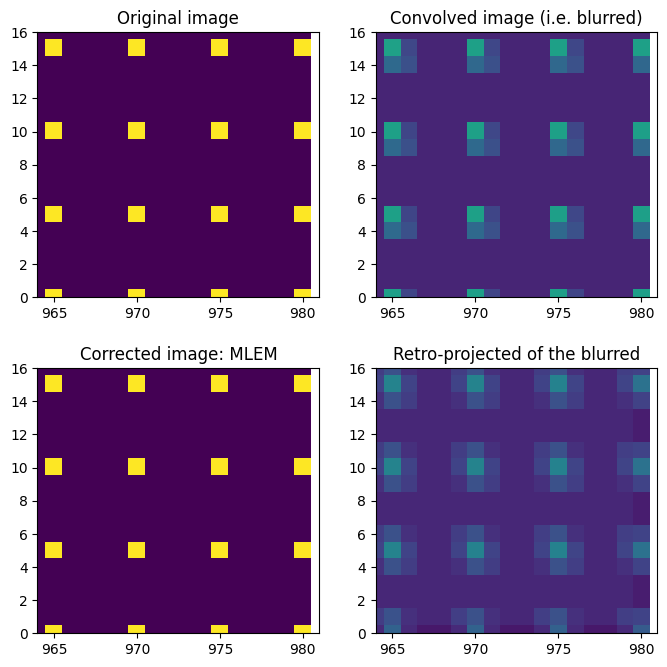

In [19]:
fix, ax = subplots(2,2, figsize=(8,8))
ax[0,0].imshow(dummy_image)
ax[0,1].imshow(dummy_blurred)
ax[1,1].imshow(csr.dot(dummy_blurred.ravel()).reshape(mask.shape))
ax[0,0].set_xlim(964,981)
ax[0,0].set_ylim(0,16)
ax[0,0].set_title("Original image")
ax[0,1].set_xlim(964,981)
ax[0,1].set_ylim(0,16)
ax[0,1].set_title("Convolved image (i.e. blurred)")
ax[1,1].set_xlim(964,981)
ax[1,1].set_ylim(0,16)
ax[1,1].set_title("Retro-projected of the blurred")
# ax[1,0].set_title("Corrected image");
ax[1,0].imshow(res)
ax[1,0].set_xlim(964,981)
ax[1,0].set_ylim(0,16)
ax[1,0].set_title("Corrected image: MLEM");

## Conclusion of the raytracing part:

We are able to simulate the path and the absorption of the photon in the thickness of the detector. 
Numba/Cython helped substentially to make the raytracing calculation much faster. 
The signal of each pixel is indeed spread on the neighboors, depending on the position of the PONI and this effect can be inverted using sparse-matrix pseudo-inversion. 
The MLEM can garanteee that the total signal is conserved and that no pixel gets negative value.

We will now save this sparse matrix to file in order to be able to re-use it in next notebook. But before saving it, it makes sense to spend some time in generating a high quality sparse matrix in throwing thousand rays per pixel in a grid of 64x64 (4 billions rays launched).

In [20]:
%time pre_csr = cythick.calc_csr(64)
hq_csr = csr_matrix(pre_csr)
save_npz("csr.npz",hq_csr)

CPU times: user 7min 23s, sys: 47.5 ms, total: 7min 23s
Wall time: 7min 23s


In [21]:
print(f"Total execution time: {time.perf_counter()-start_time:.3f} s")

Total execution time: 477.278 s
